In [52]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 
import os
import yaml
from lxml import etree as ET
from copy import copy
from scipy import ndimage
from skimage import measure

In [53]:
#! Code Heaviliy insipired by https://github.com/leekwoon/map2world

class WorldGenerator(object):
    kernel_size = 4 # for 2D map image preprocessing
    def __init__(self, binary_height_map, out_dir, config={"resolution": 0.050000}):
        """"
        binary_height_map should be a map where 0 stands for area free and 1 for area occupied
        """
        self.config = config
        self.out_dir = out_dir

        for extensions in ["gazebo", "costmap"]:
            path = os.path.join(out_dir, extensions)
            if not os.path.exists(path):
                os.makedirs(path)
        
        self.map_original = binary_height_map * 255

        # process map to make track walls thin
        track_contours = measure.find_contours(self.map_original, 0)
        assert len(track_contours) == 2
        track_contours_map = np.zeros_like(self.map_original)

        for contour in track_contours:
            y_coord = np.empty(contour.shape[0], dtype=int)
            x_coord = np.empty(contour.shape[0],  dtype=int)
            for i, element in enumerate(contour):
                y_coord[i] = element[0]
                x_coord[i] = element[1]
            track_contours_map[y_coord, x_coord] = 1

        distances = ndimage.distance_transform_edt(track_contours_map == 0)

        mask_a = self.map_original == 255 # filters everything not track
        masb_b = distances > 10 # filters everything too far away from tracjetory
        mask = mask_a & masb_b

        self.map_processed = self.map_original.copy()
        self.map_processed[mask] = 0

        # crate flipped versions
        self.map_original_flipped = np.flip(self.map_original.astype(np.float), 0)
        self.map_processes_flipped = np.flip(self.map_processed.astype(np.float), 0)


        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (self.kernel_size, self.kernel_size))
        self.map_processes_flipped = cv2.morphologyEx(self.map_processes_flipped, cv2.MORPH_CLOSE, kernel)


        # center world in frame
        #! Play around with these parameters
        # self.resolution = 0.050000
        self.resolution = config["resolution"]
        self.origin = np.array([-self.resolution * self.map_original.shape[1] / 2 , -self.resolution * self.map_original.shape[0] / 2])

        

    def write_basics(self):
        sdf = ET.Element("sdf",version="1.6")
        world = ET.SubElement(sdf, "world", name="default")

        plugin = ET.SubElement(world, "plugin", name="gazebo_ros_state", filename="libgazebo_ros_state.so")
        ros = ET.SubElement(plugin, "ros")
        namespace = ET.SubElement(ros, "namespace")
        namespace.text = "/gazebo"
        update = ET.SubElement(plugin, "update_rate")
        update.text = "1.0"

        # global light source
        include = ET.SubElement(world, 'include')
        uri = ET.SubElement(include, 'uri')
        uri.text = 'model://sun'
        # ground plane
        include = ET.SubElement(world, 'include')
        uri = ET.SubElement(include, 'uri')
        uri.text = 'model://ground_plane'
        # ode
        physics = ET.SubElement(world, 'physics', type='ode')
        real_time_update_rate = ET.SubElement(physics, 'real_time_update_rate')
        real_time_update_rate.text = '1000.0'
        max_step_size = ET.SubElement(physics, 'max_step_size')
        max_step_size.text = '0.001'
        real_time_factor = ET.SubElement(physics, 'real_time_factor')
        real_time_factor.text = '1'
        ode = ET.SubElement(physics, 'ode')
        solver = ET.SubElement(ode, 'solver')
        type = ET.SubElement(solver, 'type')
        type.text = 'quick'
        iters = ET.SubElement(solver, 'iters')
        iters.text = '150'
        precon_iters = ET.SubElement(solver, 'precon_iters')
        precon_iters.text = '0'
        sor = ET.SubElement(solver, 'sor')
        sor.text = '1.400000'
        use_dynamic_moi_rescaling = ET.SubElement(solver, 'use_dynamic_moi_rescaling')
        use_dynamic_moi_rescaling.text = '1'
        constraints = ET.SubElement(ode, 'constraints')
        cfm = ET.SubElement(constraints, 'cfm')
        cfm.text = '0.00001'
        erp = ET.SubElement(constraints, 'erp')
        erp.text = '0.2'
        contact_max_correcting_vel = ET.SubElement(constraints, 'contact_max_correcting_vel')
        contact_max_correcting_vel.text = '2000.000000'
        contact_surface_layer = ET.SubElement(constraints, 'contact_surface_layer')
        contact_surface_layer.text = '0.01000'

        # scene
        scene = ET.SubElement(world, 'scene')
        ambient = ET.SubElement(scene, 'ambient')
        ambient.text = '0.4 0.4 0.4 1'
        background = ET.SubElement(scene, 'background')
        background.text = '0.7 0.7 0.7 1'
        shadows = ET.SubElement(scene, 'shadows')
        shadows.text = 'true'

        # gui
        gui = ET.SubElement(world, 'gui', fullscreen='0')
        camera = ET.SubElement(gui, 'camera', name='user_camera')
        pose = ET.SubElement(camera, 'pose')
        pose.text = '0.0 0.0 17.0 -1.5708 1.5708 0'
        view_controller = ET.SubElement(camera, 'view_controller')
        view_controller.text ='orbit'

        return sdf, world

    def generate_v_wall(self, parent, x, y, length, id):
        collision = ET.SubElement(parent, 'collision', name='obstacle_{}'.format(id))
        pose = ET.SubElement(collision, 'pose')
        pose.text = '{} {} 0 0 0 1.5708'.format(str(x), str(y))
        geometry = ET.SubElement(collision, 'geometry')
        box = ET.SubElement(geometry, 'box')
        size = ET.SubElement(box, 'size')
        size.text = '{} 0.15 1.0'.format(str(length))

        visual = ET.SubElement(parent, 'visual', name='obstacle_{}'.format(id))
        pose = ET.SubElement(visual, 'pose')
        pose.text = '{} {} 0 0 0 1.5708'.format(str(x), str(y))
        geometry = ET.SubElement(visual, 'geometry')
        box = ET.SubElement(geometry, 'box')
        size = ET.SubElement(box, 'size')
        size.text = '{} 0.15 1.0'.format(str(length))
        material = ET.SubElement(visual, 'material')
        script = ET.SubElement(material, 'script')
        uri = ET.SubElement(script, 'uri')
        uri.text = 'file://media/materials/scripts/gazebo.material'
        name = ET.SubElement(script, 'name')
        name.text = 'Gazebo/Grey'
        ambient = ET.SubElement(material, 'ambient')
        ambient.text = '1 1 1 1'

    def generate_h_wall(self, parent, x, y, length, id):
        collision = ET.SubElement(parent, 'collision', name='obstacle_{}'.format(id))
        pose = ET.SubElement(collision, 'pose')
        pose.text = '{} {} 0 0 0 0'.format(str(x), str(y))
        geometry = ET.SubElement(collision, 'geometry')
        box = ET.SubElement(geometry, 'box')
        size = ET.SubElement(box, 'size')
        size.text = '{} 0.15 1.0'.format(str(length))

        visual = ET.SubElement(parent, 'visual', name='obstacle_{}'.format(id))
        pose = ET.SubElement(visual, 'pose')
        pose.text = '{} {} 0 0 0 0'.format(str(x), str(y))
        geometry = ET.SubElement(visual, 'geometry')
        box = ET.SubElement(geometry, 'box')
        size = ET.SubElement(box, 'size')
        size.text = '{} 0.15 1.0'.format(str(length))
        # cylinder = ET.SubElement(geometry, 'cylinder')
        material = ET.SubElement(visual, 'material')
        script = ET.SubElement(material, 'script')
        uri = ET.SubElement(script, 'uri')
        uri.text = 'file://media/materials/scripts/gazebo.material'
        name = ET.SubElement(script, 'name')
        name.text = 'Gazebo/Grey'
        ambient = ET.SubElement(material, 'ambient')
        ambient.text = '1 1 1 1'
  
    def is_v_wall_type(self, r, c, gridmap):
        """
            Return True if it is belong to vertical wall ...

            This function helps to reduce the number of walls to generate
        """

        vl = 0 # expected vertical length
        rr = r
        cc = c
        while rr<self.map_processes_flipped.shape[0] and cc<self.map_processes_flipped.shape[1] and self.map_processes_flipped[rr][cc] == 255:
            rr += 1
            vl += 1
            
        hl = 0 # expected horizontal length
        rr = r
        cc = c
        while rr<self.map_processes_flipped.shape[0] and cc<self.map_processes_flipped.shape[1] and self.map_processes_flipped[rr][cc] == 255:
            cc += 1
            hl += 1
        return vl > hl

    def generate_map(self):
        
        # save world file and config
        transformed_map = self.map_original
        map_inverted = abs(255-transformed_map)
        cv2.imwrite(os.path.join(self.out_dir, "gazebo", "map.pgm"), map_inverted)

        yaml_file_content={
            "image": "map.pgm",
            "resolution": self.config["resolution"],
            "origin": [-self.resolution * transformed_map.shape[1] / 2, -self.resolution * transformed_map.shape[0] / 2, 0],
            "negate": 0,
            "occupied_thresh": 0.65,
            "free_thresh": 0.196
        }

        with open(os.path.join(self.out_dir, "gazebo", "map.yaml"), 'w') as outfile:
            yaml.dump(yaml_file_content, outfile, default_flow_style=False)

        # save costmap and config
        with open(os.path.join(self.out_dir, "costmap", "map.npy"), 'wb') as f:
            np.save(f, self.map_original_flipped)
            #np.save(f, self.map_original)
        yaml_file_content={
           "origin_x": -self.resolution * transformed_map.shape[1] / 2,
           "origin_y": -self.resolution * transformed_map.shape[0] / 2,
           "resolution": self.resolution
        }

        with open(os.path.join(self.out_dir, "costmap", "map.yaml"), 'w') as outfile:
            yaml.dump(yaml_file_content, outfile, default_flow_style=False)




    def generate(self):
        sdf, world = self.write_basics()

        model = ET.SubElement(world, 'model', name='obstacle')
        static = ET.SubElement(model, 'static')
        static.text = '1'
        pose = ET.SubElement(model, 'pose', frame='')
        pose.text = '0 0 0 0 0 0'
        link = ET.SubElement(model, 'link', name='obstacle')
        
        parent = link

        flag = copy(self.map_processes_flipped) # 255 -> need to build wall, 0 -> already ...

        wall_count = 0
        while True:
            idxs = np.argwhere(flag == 255)
            if len(idxs) == 0:
                break

            wall_count += 1

            start_r, start_c = idxs[0]
                
            h_wall = False
            v_wall = False
            end_r = start_r
            end_c = start_c
            # if self.map_flipped[end_r + 1][end_c] == 255 :
            if self.is_v_wall_type(start_r, start_c, self.map_processes_flipped):
                v_wall = True
                while end_r<self.map_processes_flipped.shape[0] and end_c<self.map_processes_flipped.shape[1] and self.map_processes_flipped[end_r][end_c] == 255:
                    flag[end_r][end_c] = 0
                    end_r += 1
                center_x = self.origin[0] + int((start_c + end_c) / 2) * self.resolution
                center_y = self.origin[1] + int((start_r + end_r) / 2) * self.resolution
                l = (end_r - start_r) * self.resolution
                self.generate_v_wall(link, center_x, center_y, l, wall_count)
            elif self.map_processes_flipped[end_r][end_c + 1] == 255:
                h_wall = True
                while  end_r<self.map_processes_flipped.shape[0] and end_c<self.map_processes_flipped.shape[1] and self.map_processes_flipped[end_r][end_c] == 255:
                    flag[end_r][end_c] = 0
                    end_c += 1
                center_x = self.origin[0] + int((start_c + end_c) / 2) * self.resolution
                center_y = self.origin[1] + int((start_r + end_r) / 2) * self.resolution
                l = (end_c - start_c) * self.resolution
                self.generate_h_wall(link, center_x, center_y, l, wall_count)
            else:
                flag[end_r][end_c] = 0
                continue
        tree = ET.ElementTree(sdf)
        tree.write(os.path.join(self.out_dir, "gazebo", "gazebo_world.world"), pretty_print=True)

        self.generate_map()

In [54]:
base_path = "../../../out/tracks/track_3"

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


/tmp/ipykernel_10978/488109074.py:42: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.map_original_flipped = np.flip(self.map_original.astype(np.float), 0)
/tmp/ipykernel_10978/488109074.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.map_processes_flipped = np.flip(self.map_processed.astype(np.float), 0)


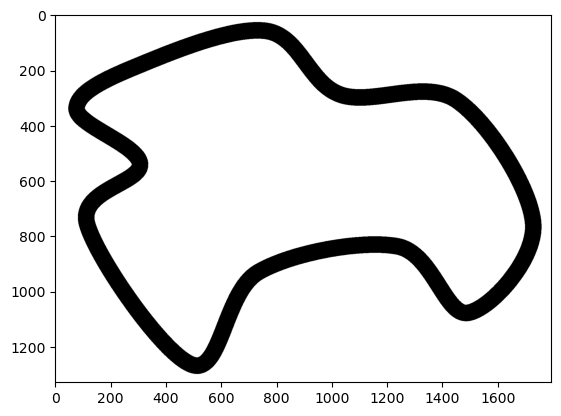

In [55]:
import cv2
from skimage import measure
from utils.classify_points import classify_points
from models.point import Point

img = cv2.imread(os.path.join(base_path, "track.jpeg"), cv2.IMREAD_GRAYSCALE)
#_, img_binarized = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
_, img_binarized = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
img_binarized = (img_binarized == 255) * 1
print(img_binarized)
plt.imshow(img_binarized, 'gray',vmin=0,vmax=1)

# generate gazebo_world
world_generator = WorldGenerator(img_binarized, base_path, {"resolution": 0.05000})
world_generator.generate()

In [ ]:
base_path = "../../../out/tracks/track_3"

[[267.02996087 266.51078777 265.99436084 ... 424.7257939  425.39981194
  426.07511075]
 [266.17663308 265.65579233 265.13770007 ... 423.9870281  424.66221871
  425.33868858]
 [265.32432983 264.80181268 264.28204631 ... 423.2493355  423.92570104
  424.60334431]
 ...
 [361.80796011 361.01246516 360.21798956 ... 333.12159942 333.7439138
  334.36806068]
 [362.41412776 361.61996626 360.82682827 ... 333.9056753  334.52653109
  335.1492205 ]
 [363.0220379  362.2292092  361.43740814 ... 334.69090218 335.31030405
  335.93154064]]


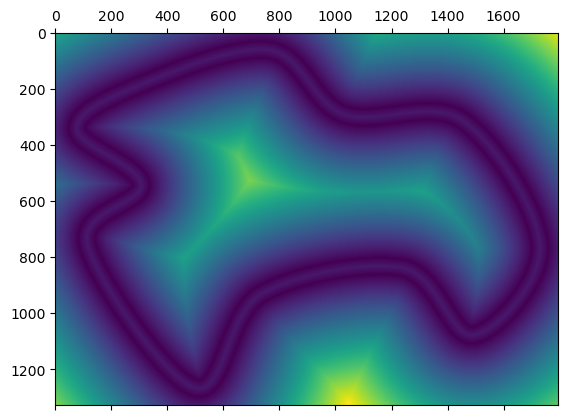

In [42]:
from scipy import ndimage
track_contours = measure.find_contours(img_binarized, 0)
assert len(track_contours) == 2

track_contours_binarized = np.zeros_like(img_binarized)

for contour in track_contours:
    y_coord = np.empty(contour.shape[0], dtype=int)
    x_coord = np.empty(contour.shape[0],  dtype=int)
    for i, element in enumerate(contour):
        y_coord[i] = element[0]
        x_coord[i] = element[1]
    track_contours_binarized[y_coord, x_coord] = 1

distances = ndimage.distance_transform_edt(track_contours_binarized == 0)
plt.matshow(distances)
print(distances)

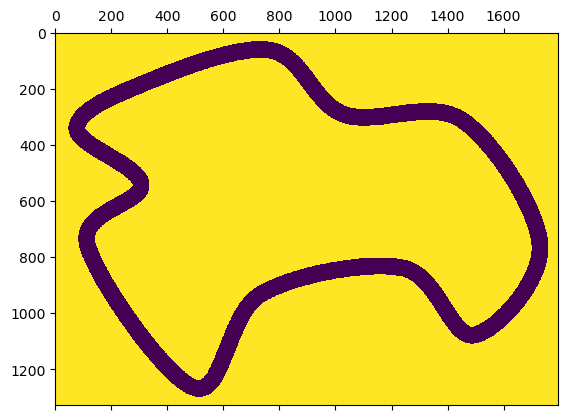

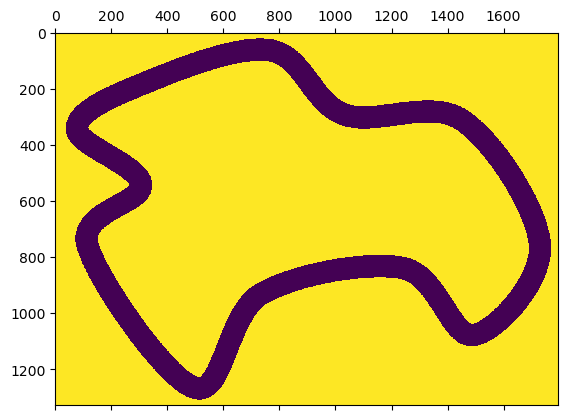

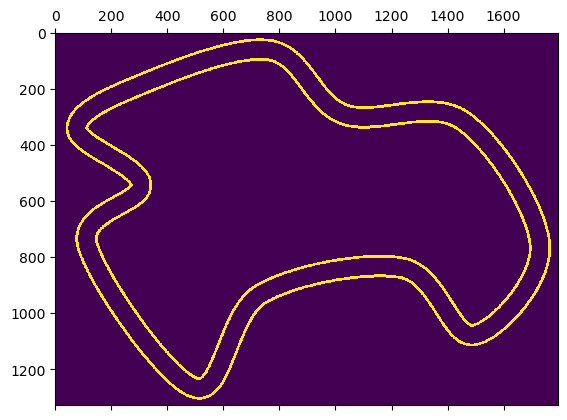

In [50]:
mask_a = img_binarized == 1
masb_b = distances > 10

mask = mask_a & masb_b
plt.matshow(img_binarized)
plt.matshow(mask)

img_processed = img_binarized.copy()
img_processed[mask] = 0
plt.matshow(img_processed)